In [1]:
#enveloping potential
# simple Example plot Enveloped Potential with two Harmonic Oscilators
##Imports:
import os, sys as csys
os.getcwd()
csys.path.append(os.getcwd()+"/../..")
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

import datetime

from tqdm.autonotebook import tqdm
import tempfile
import gc 


from ensembler.integrator import monteCarloIntegrator, metropolisMonteCarloIntegrator
from ensembler.integrator import positionVerletIntegrator, leapFrogIntegrator
from ensembler.conditions.periodicBoundaryCondition import periodicBoundaryCondition 
from ensembler.system import system, eds_system

import ensembler.potentials.ND as pot
import ensembler.potentials.TwoD as pot2D
import ensembler.visualisation.plotPotentials as exPlot


%matplotlib inline

/home/bschroed/anaconda3_7/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# UGLY Plotting Functions! to be improved!

here are the plot functions defined. below the sims


In [4]:
#ENERGIES Sampling - CURRENTLY NOT USED!
def plot_energy_traj(s_val_pos_dict, out_tmp_dir):
    tmp_visit_x, tmp_visit_y = (s_val_pos_dict[100.0][0], s_val_pos_dict[100.0][1])
    state1 = V1.ene(list(zip(tmp_visit_x, tmp_visit_y)))
    state2 = V2.ene(list(zip(tmp_visit_x, tmp_visit_y)))
    edsPot.s = 1.0
    Vrenergies = edsPot.ene(list(zip(tmp_visit_x, tmp_visit_y)))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x=[t for t in range(len(Vrenergies))], y=Vrenergies, label="eds_pot", alpha= 0.1, s=1)
    ax.scatter(x=[t for t in range(len(state1))], y=state1, label="state1", alpha= 0.1, s=1)
    ax.scatter(x=[t for t in range(len(state2))], y=state2, label="state2", alpha= 0.1, s=1)
    ax.set_title("Sampled Energies")
    ax.set_ylabel("Potential")
    ax.set_xlabel("t")
    ax.legend()

    out_path = out_tmp_dir+"/sampled_energies_at_s100.png"
    print(out_path)
    fig.savefig(out_path)
    plt.close(fig)
    return out_path

In [5]:
#write out energy traj
def write_out_etraj(traj, out_path, V1, V2):
    visited_positions = [state_positions[0] for state_positions in traj.position]
    state1 = V1.ene(visited_positions)
    state2 = V2.ene(visited_positions)
    Vrenergies = np.array(traj.totPotEnergy)

    out_file = open(out_path, "w")
    out_file.write("t\tV1\tV2\tVr\n")#HEADER
    for t, V1, V2, Vr in zip(traj.index, state1, state2, Vrenergies):
        out_file.write(str(t)+"\t"+str(V1)+"\t"+str(V2)+"\t"+str(Vr)+"\n")

    out_file.close()

## Build Up 2D EDS-Potential

In [6]:
#BUILD Potential:
#params:
barrier = 50 #kT - minimal barrier in system
optimal_ses = {#50: 0.006
               #2.5: 0.122,
               5: 0.061,
               10: 0.03,
               20: 
               0.015, 
               }
               
#Potentials
amplitude = barrier/2
shift  = np.rad2deg(0.5*math.pi)
Eoff = [0,0]

print(amplitude)
V1 = pot2D.wavePotential(phase_shift=(shift,shift), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
V2 = pot2D.wavePotential(phase_shift=(0.0, 0.0), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
edsPot1 = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)
edsPot2 = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)


25.0


In [10]:
#Simulation Setup
##Build System
periodic_bound = periodicBoundaryCondition(boundary=[[-180,180], [-180,180]])
integrator = metropolisMonteCarloIntegrator(fixedStepSize=[1,1]) 

#sys=system(potential=edsPot, integrator=integrator, conditions=[periodic_bound])


##STEPS
initial_position = None #[180, -180]
each_sim = 200#400 #has steps:
values = [0.5,0.01] #sorted([10, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01]+[optimal_ses[barrier]], reverse=True)
svals = values+list(reversed(values))   # svalues
trials = 1000#0   #how often the svalue sequence is repeated:

print("svalue sequence - #s="+str(len(svals))+" ", svals)

svalue sequence - #s=4  [0.5, 0.01, 0.01, 0.5]


## Simulate Replica Systems:

In [11]:
#run multiple replicas
tmp_dir = tempfile.gettempdir()+"/eds_simulations_TESTAGAIN"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
os.chdir(tmp_dir)
tmp_dir = tmp_dir+"/2_replica_eds"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
import pandas as pd

for barrier in tqdm(optimal_ses, desc="Barrier: "):
    approach_dir = tmp_dir+"/simulation_with_"+str(barrier)+"kt_barrier"
    if(not os.path.exists(approach_dir)): os.mkdir(approach_dir)
        
        
    ##STEPS
    initial_position = None #[180, -180]
    each_sim = 200
    trials = 5000   #how often the svalue sequence is repeated:

    values = [0.5,0.01] #sorted([10, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01]+[optimal_ses[barrier]], reverse=True)
    svals = values+list(reversed(values))   # svalues
    replicas = 10

    start_t = datetime.datetime.now()

    #plot_wholeSimSpace(edsPot, out_path = tmp_dir+"/SimSpace_"+str(barrier)+"kT.png", resolution=1024)

    #METROPOLIS CRITERION
    ##random part of Metropolis Criterion:
    import scipy.constants as const
    _defaultRandomness = lambda V1, V2: (np.random.rand() <= np.exp(-1.0 / (const.gas_constant / 1000.0 * 298) * (V1 - V2))) #pseudocount  for equal energies
    ##default Metropolis Criterion
    _defaultMetropolisCriterion = lambda V1, V2: (V1 < V2 or _defaultRandomness(V1, V2))

    def MC_exchange(eds_potential, curPos, s_old, s_new):
        tmp_s = eds_potential.s
        eds_potential.s = s_old
        V1 = np.sum(eds_potential.ene(curPos))
        V1_00 = np.sum(eds_potential.ene([0,0]))
        eds_potential.s = s_new
        V2 = np.sum(eds_potential.ene(curPos))
        V2_00 = np.sum(eds_potential.ene([0,0]))

        eoff = V2_00 - V1_00
        V2 -= eoff*2

        eds_potential.s = tmp_s
        #print("Pots: V1 - "+str(V1)+" \t V2 - "+str(V2)+"\t\t Eoff "+str(eoff))
        return _defaultMetropolisCriterion(V2, V1)


    def MC_exchange2(sys1, sys2):
        s1 = sys1.potential.s
        s2 = sys2.potential.s

        V1_s1 = sum(sys1.potential.ene(sys1._currentPosition))

        V2_s2 = sum(sys2.potential.ene(sys2._currentPosition))

        sys1.potential.s = s2 
        V1_s2 = sum(sys1.potential.ene(sys1._currentPosition))

        sys2.potential.s = s1 
        V2_s1 = sum(sys2.potential.ene(sys2._currentPosition))

        sys1.potential.s = s1
        sys2.potential.s = s2 

        exchange = _defaultMetropolisCriterion((V2_s1+V1_s2),(V1_s1+V2_s2))
        #print("Exchange val = ", exchange, "pots in order: ", (V1_s1+V2_s2), (V2_s1+V1_s2) )
        return exchange
    amplitude = barrier/2
    shift  = np.rad2deg(0.5*math.pi)
    Eoff = [0,0]

    print(barrier)
    V1 = pot2D.wavePotential(phase_shift=(shift,shift), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    V2 = pot2D.wavePotential(phase_shift=(0.0, 0.0), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    edsPot1 = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)
    edsPot2 = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)


    start=0
    syst = None
    for replica in tqdm(range(start, replicas), desc="Replicas: "):
        ##INIT REPLICA
        ###fILE hANDLING
        replica_out = approach_dir+"/replica_"+str(replica)
        if(not os.path.exists(replica_out)):
            os.mkdir(replica_out)

        ###Build System
        sys1=system(potential=edsPot1, integrator=integrator, conditions=[periodic_bound], 
                        position=initial_position)
        sys2=system(potential=edsPot2, integrator=integrator, conditions=[periodic_bound], 
                    position=initial_position)
        del sys1.trajectory[:]
        del sys2.trajectory[:]

        sys1.potential.s = 0.5
        sys2.potential.s = 0.01

        ## SIMULATE REPLICA
        start_sim = datetime.datetime.now()
        s_val_posDict = {}  #OUT
        current_s_index = 0
        current_s_direction = 1

        for trial in tqdm(range(trials), desc="Current Simulation of replica "+str(replica)+": "):
            cur_state1 = sys1.simulate(each_sim, withdrawTraj=False)
            cur_state2 = sys2.simulate(each_sim, withdrawTraj=False)

            if(MC_exchange2(sys1, sys2)):
                #print("\texchange")
                sys1._currentPosition = cur_state2.position
                sys2._currentPosition = cur_state1.position
            else:
                pass
                #print("No\t Exchange")

        s_val_posDict.update({sys2.potential.s : sys2.getTrajectory()})
        s_val_posDict.update({sys1.potential.s : sys1.getTrajectory()})

        end_sim = datetime.datetime.now()
        duration_sim = end_sim-start_sim


        #plotting:
        print("ploting")
        start_plot = datetime.datetime.now()
        out_path, fig = plot_s_dependent_sim(s_val_posDict, edsPot=edsPot1, plot_trajs=True, out_path=replica_out+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT_withTraj.png")
        end_plot = datetime.datetime.now()
        duration_plot = end_plot-start_plot

        for s in s_val_posDict:
            write_out_etraj(traj=s_val_posDict[s], out_path=replica_out+"/replica_traj_s"+str(s)+".dat", V1=sys1.potential.V_is[0], V2=sys1.potential.V_is[1])
        del sys1, sys2
        
        

    end_t = datetime.datetime.now()
    duration = end_t-start_t
    print("Done - duration: ", duration)
    print("Done - simulation duration: ", duration_sim)
    print("Done - plotting duration: ", duration_plot)


5


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting
Done - duration:  1:31:41.146018
Done - simulation duration:  0:07:26.585562
Done - plotting duration:  0:01:13.132079
10


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting
Done - duration:  1:31:49.811249
Done - simulation duration:  0:07:34.601841
Done - plotting duration:  0:01:13.191209
20


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting


ploting
Done - duration:  1:32:01.235966
Done - simulation duration:  0:07:38.753658
Done - plotting duration:  0:01:13.912911


In [8]:
#run multiple replicas
tmp_dir = tempfile.gettempdir()+"/eds_simulation3"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
os.chdir(tmp_dir)

import pandas as pd

approach_dir = tmp_dir+"/simulation_with_"+str(barrier)+"kT_barrier"
replicas = 1#0

start_t = datetime.datetime.now()

#plot_wholeSimSpace(edsPot, out_path = tmp_dir+"/SimSpace_"+str(barrier)+"kT.png", resolution=1024)

start=0
syst = None
for replica in tqdm(range(start, replicas), desc="Replicas: "):
    ##INIT REPLICA
    ###fILE hANDLING
    replica_out = tmp_dir+"/replica_"+str(replica)
    if(not os.path.exists(replica_out)):
        os.mkdir(replica_out)

    ###Build System
    sys=system(potential=edsPot, integrator=integrator, conditions=[periodic_bound], 
                    position=initial_position)
    del sys.trajectory[:]

    ## SIMULATE REPLICA
    start_sim = datetime.datetime.now()
    s_val_posDict = {}  #OUT
    for s in tqdm(svals*seq_repeat, desc="Current Simulation of replica "+str(replica)+": "):
        sys.potential.s = s
        cur_state = sys.simulate(each_sim, withdrawTraj=False)
        tmpTraj = sys.trajectory[-each_sim:]
        
        if(s not in s_val_posDict):
            s_val_posDict.update({s:sys.getTrajectory()[-each_sim:]})
        else:
            s_val_posDict[s] = pd.concat([s_val_posDict[s], sys.getTrajectory()[-each_sim:]])
        #print(s, start_ind, end_ind)    
    end_sim = datetime.datetime.now()
    duration_sim = end_sim-start_sim

    traj = sys.getTrajectory()
    
    #plotting:
    print("ploting")
    start_plot = datetime.datetime.now()
    #plot_wholeSimSpace(edsPot, out_path = replica_out+"/SimSpace_withTraj_"+str(barrier)+"kT.png", traj=traj)
    #if(replica == 0):
       # out_path, fig = plot_s_dependent_sim(s_val_posDict, plot_trajs=False, out_path=tmp_dir+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT.png", resolution=1024)
    #out_path, fig = plot_s_dependent_sim(s_val_posDict, plot_trajs=True, out_path=replica_out+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT_withTraj.png")
    end_plot = datetime.datetime.now()
    duration_plot = end_plot-start_plot
    
    for s in s_val_posDict:
        write_out_etraj(traj=s_val_posDict[s], out_path=replica_out+"/replica_traj_s"+str(s)+".dat", V1=sys.potential.V_is[0], V2=sys.potential.V_is[1])
    sys.writeTrajectory(replica_out+"/total_replica_traj.dat")

    del sys
    
end_t = datetime.datetime.now()
duration = end_t-start_t
print("Done - duration: ", duration)
print("Done - simulation duration: ", duration_sim)
print("Done - plotting duration: ", duration_plot)


NameError: name 'edsPot' is not defined

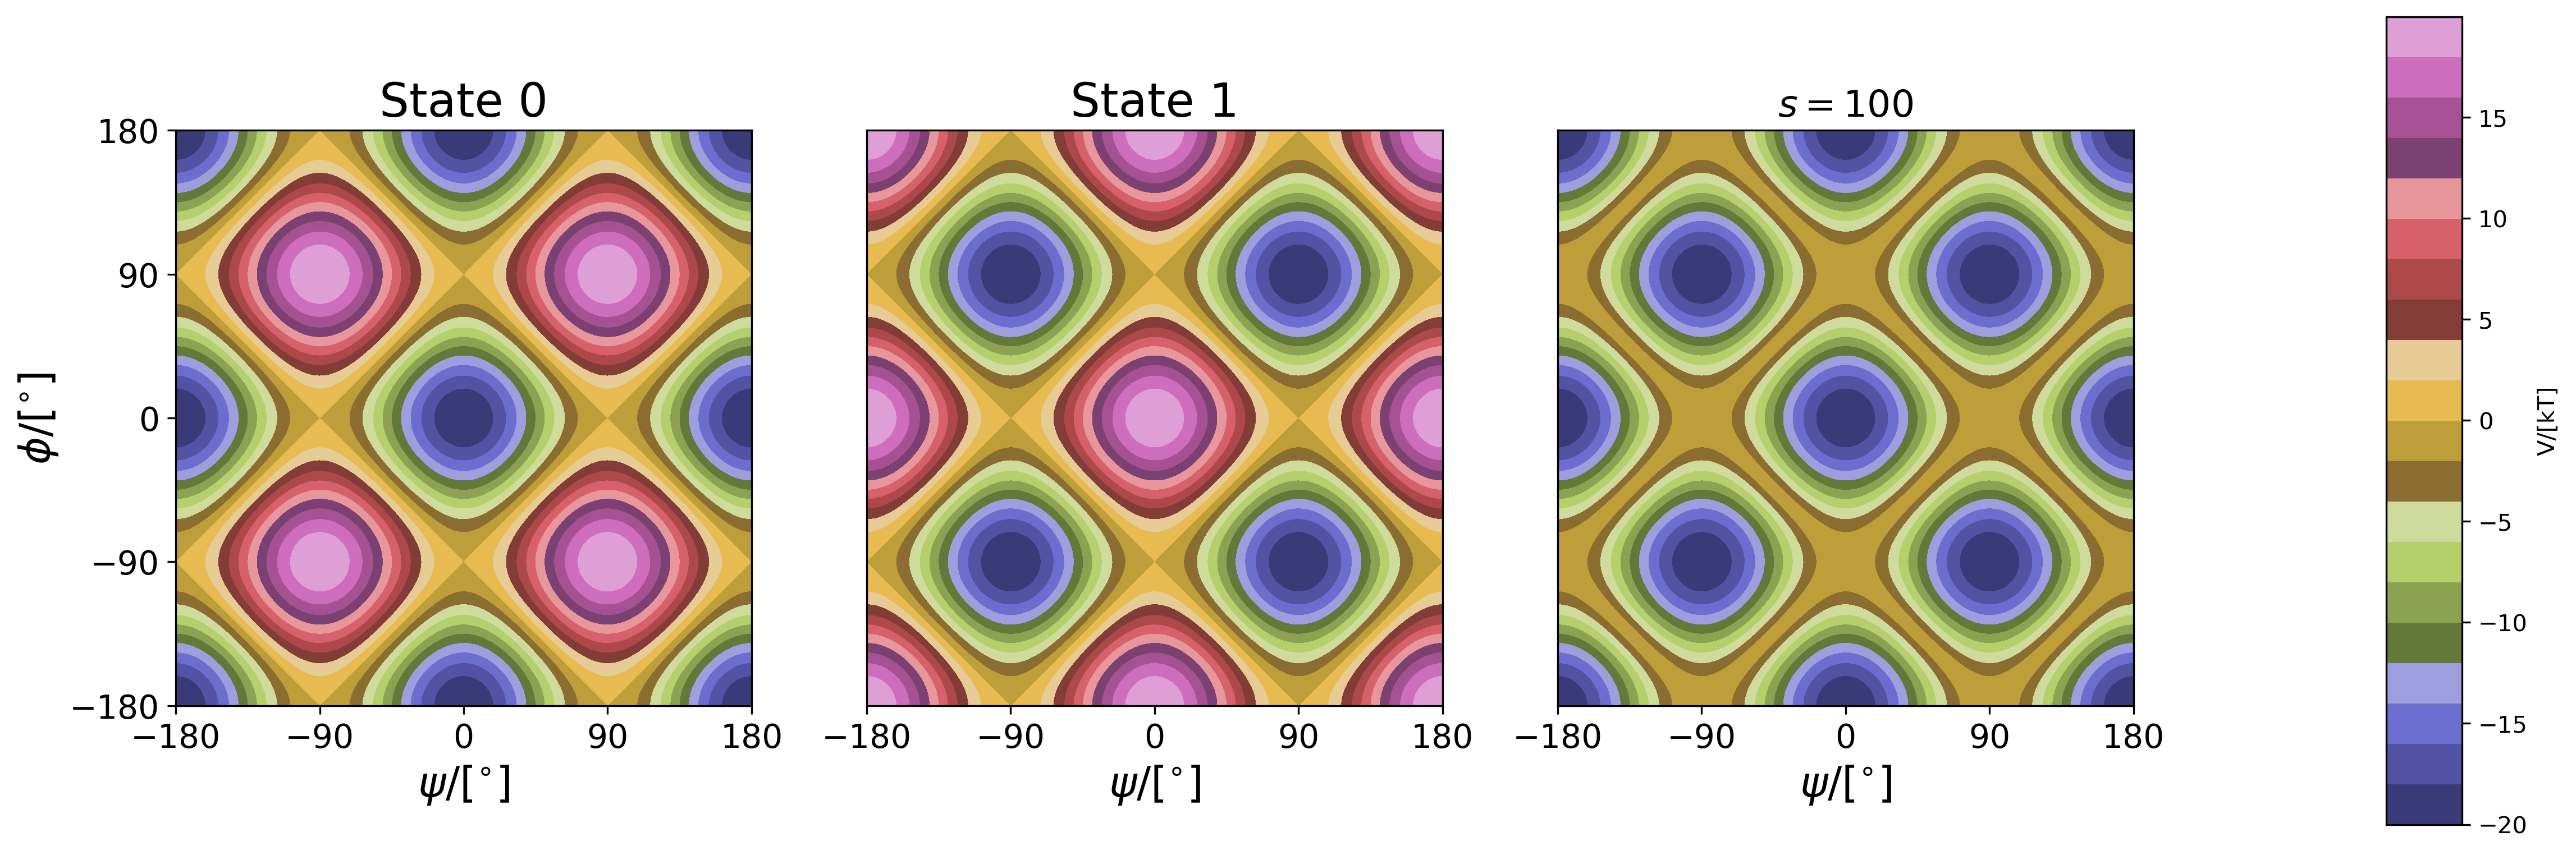

In [12]:
plot_wholeSimSpace(edsPot, out_path = replica_out+"/SimSpace.png", verbose=True)

In [ ]:
plot_wholeSimSpace(edsPot, out_path = replica_out+"/SimSpace_withTraj.png", traj=traj, verbose=True)

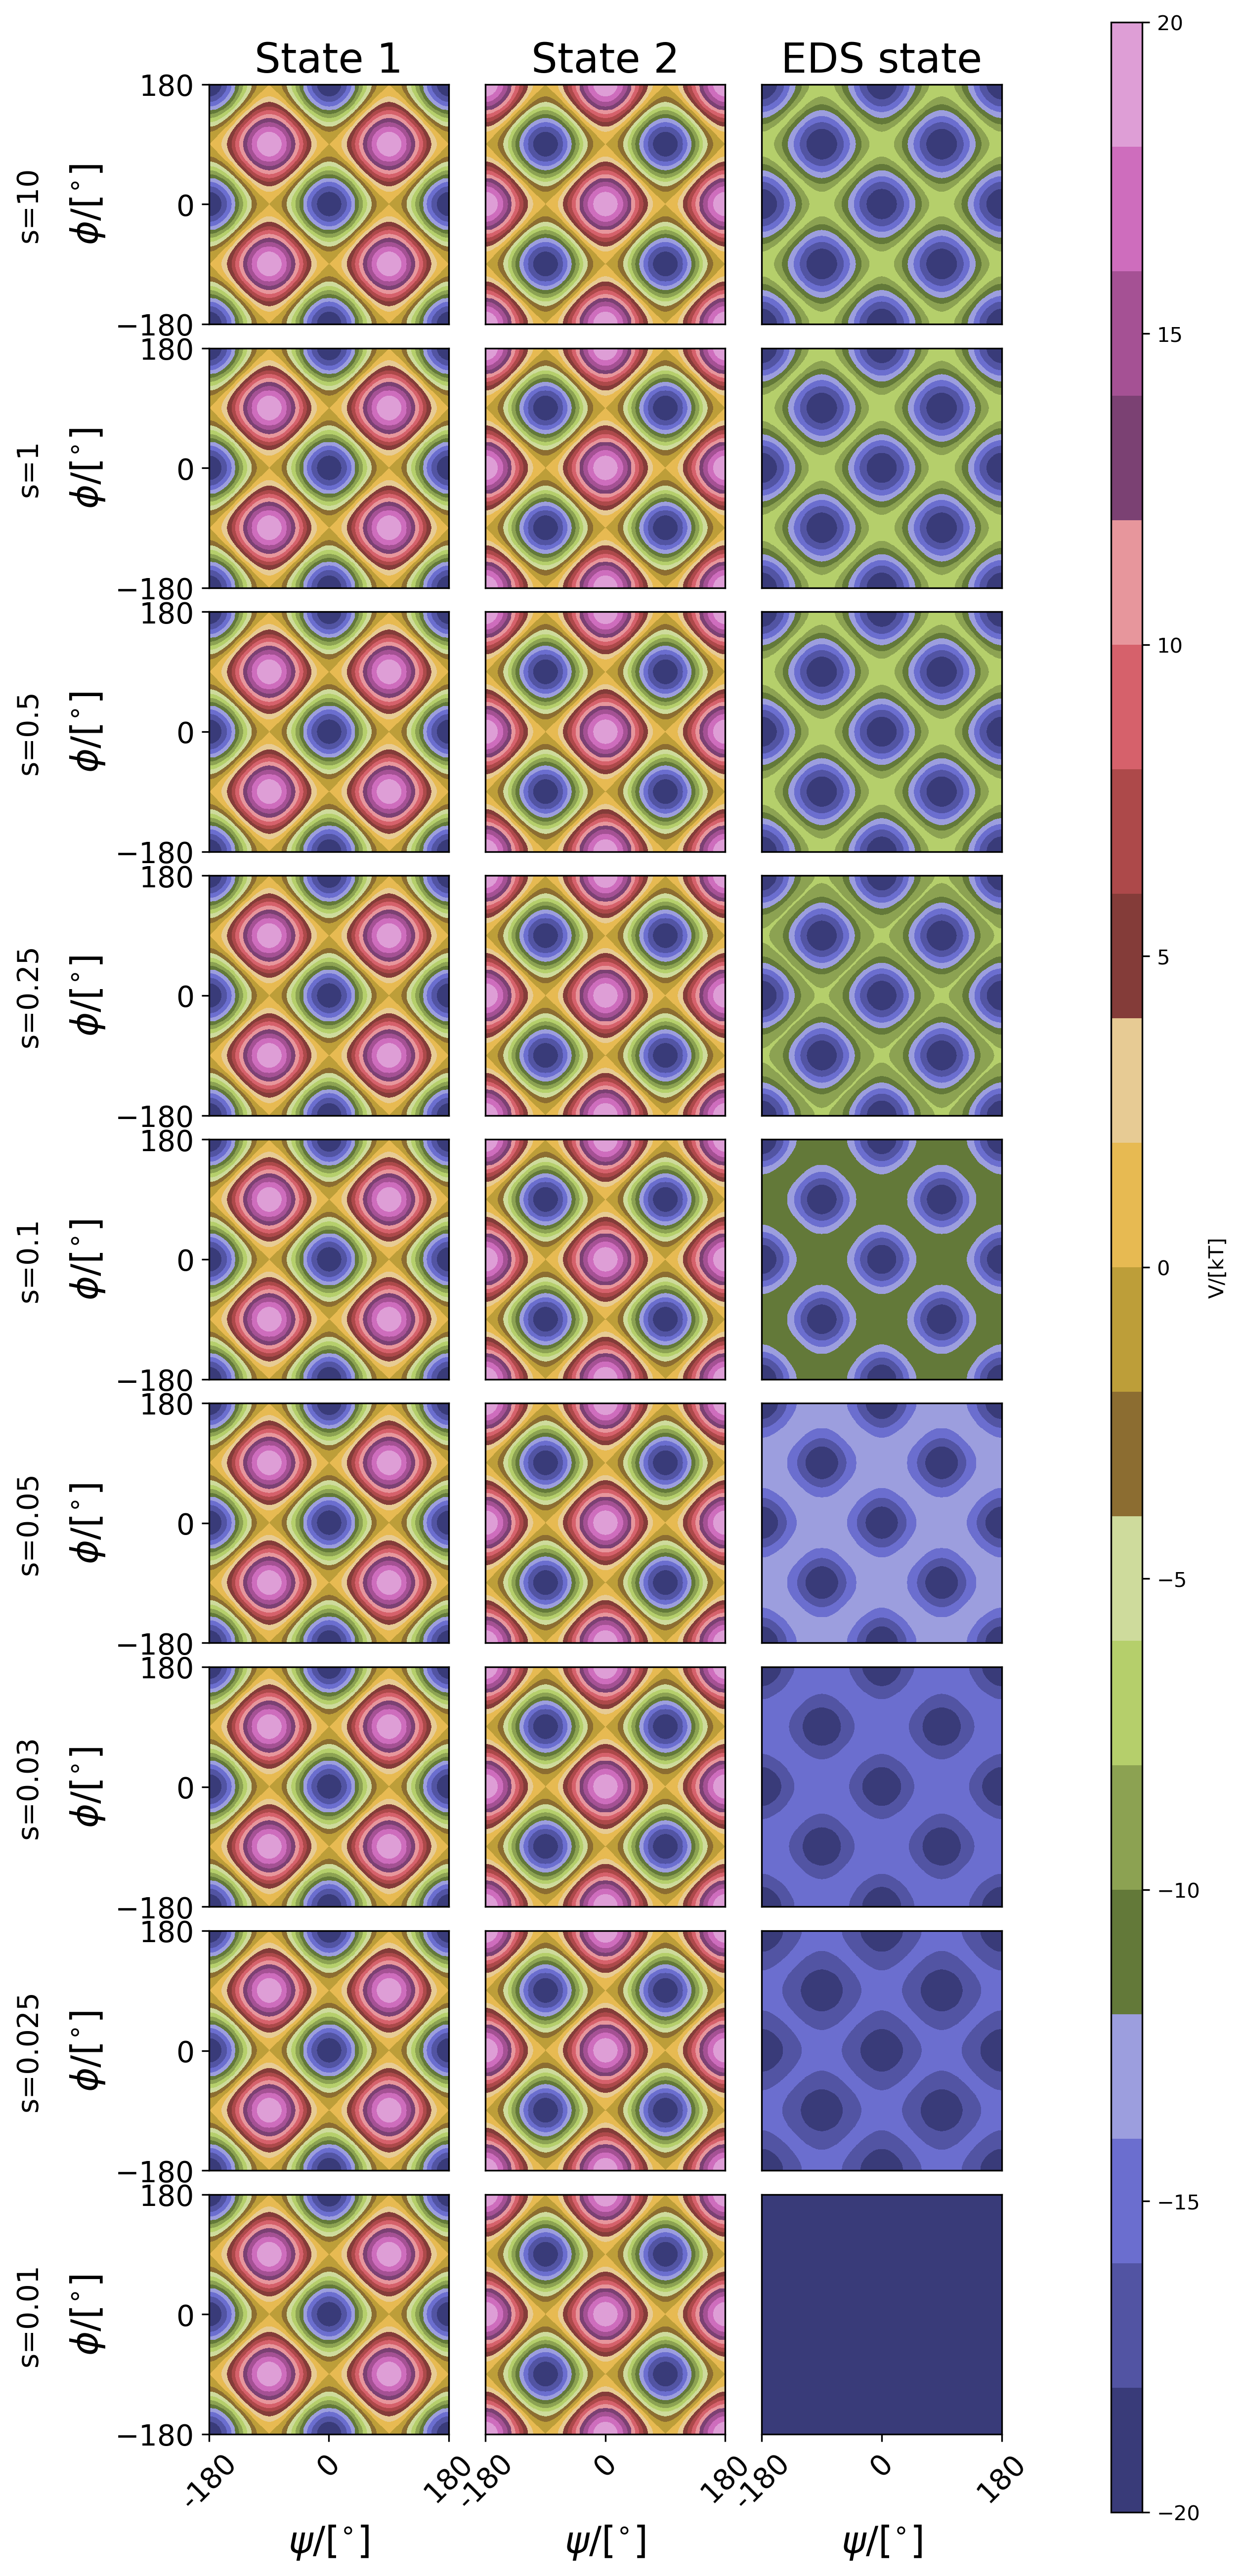

In [33]:
out_path, fig = plot_s_dependent_sim(s_val_posDict, plot_trajs=False, 
                                     out_path=replica_out+"/s_dependent_sampling_relBarrier.png", verbose=True)
fig

In [ ]:
out_path, fig = plot_s_dependent_sim(s_val_posDict, plot_trajs=True, 
                                     out_path=replica_out+"/s_dependent_sampling_relBarrier.png", verbose=True)
fig

# PRODUCTION

In [ ]:
def simulate_replicas(out_dir:str, barrier, opt_s, replicas=10):
    if(not os.path.exists(out_dir)):
        os.mkdir(out_dir)
    
    start_t = datetime.datetime.now()
    #Potentials
    amplitude = barrier/2
    shift  = np.rad2deg(0.5*math.pi)
    Eoff = [0,0]

    V1 = pot2D.wavePotential(phase_shift=(shift,shift), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    V2 = pot2D.wavePotential(phase_shift=(0.0, 0.0), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    edsPot = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)
    #plot_wholeSimSpace(eds_pot=edsPot, out_path = out_dir+"/SimSpace_"+str(barrier)+"kT.png", resolution=1024)

    #Simulation Setup
    ##Build System
    periodic_bound = periodicBoundaryCondition(boundary=[[-180,180], [-180,180]])
    integrator = metropolisMonteCarloIntegrator(fixedStepSize=[1,1]) 

    ##STEPS
    initial_position = None #[180, -180]
    each_sim = 1000 #has steps:
    values = sorted([10, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01]+[opt_s], reverse=True)
    svals = values+list(reversed(values))   # svalues
    seq_repeat = 100   #how often the svalue sequence is repeated:

    print("svalue sequence - #s="+str(len(svals))+" ", svals)
    

    ## SIMULATE

    start=9
    syst = None
    for replica in tqdm(range(start, replicas), desc="Replicas: "):
        ##INIT REPLICA
        ###fILE hANDLING
        replica_out = out_dir+"/replica_"+str(replica)
        if(not os.path.exists(replica_out)):
            os.mkdir(replica_out)

        ###Build System
        sys=system(potential=edsPot, integrator=integrator, conditions=[periodic_bound], 
                        position=initial_position)
        del sys.trajectory[:]

        ## SIMULATE REPLICA
        start_sim = datetime.datetime.now()
        s_val_posDict = {}  #OUT
        for s in tqdm(svals*seq_repeat, desc="Current Simulation of replica "+str(replica)+": "):
            sys.potential.s = s
            cur_state = sys.simulate(each_sim, withdrawTraj=False)
            tmpTraj = sys.trajectory[-each_sim:]

            if(s not in s_val_posDict):
                s_val_posDict.update({s:sys.getTrajectory()[-each_sim:]})
            else:
                s_val_posDict[s] = pd.concat([s_val_posDict[s], sys.getTrajectory()[-each_sim:]])
            #print(s, start_ind, end_ind)    
        end_sim = datetime.datetime.now()
        duration_sim = end_sim-start_sim

        traj = sys.getTrajectory()

        #plotting:
        print("ploting")
        start_plot = datetime.datetime.now()
        plot_wholeSimSpace(edsPot, out_path = replica_out+"/SimSpace_withTraj_"+str(barrier)+"kT.png", traj=traj)
        if(replica == 0):
            out_path, fig = plot_s_dependent_sim(s_val_posDict, edsPot=edsPot, plot_trajs=False, out_path=out_dir+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT.png", resolution=1024)
        out_path, fig = plot_s_dependent_sim(s_val_posDict, edsPot=edsPot, plot_trajs=True, out_path=replica_out+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT_withTraj.png")
        end_plot = datetime.datetime.now()
        duration_plot = end_plot-start_plot

        for s in s_val_posDict:
            write_out_etraj(traj=s_val_posDict[s], out_path=replica_out+"/replica_traj_s"+str(s)+".dat", V1=sys.potential.V_is[0], V2=sys.potential.V_is[1])
        sys.writeTrajectory(replica_out+"/total_replica_traj.dat")
        del sys, traj
        
        gc.collect()

    del edsPot
    end_t = datetime.datetime.now()
    duration = end_t-start_t
    print("Done - duration: ", duration)
    print("Done - simulation duration: ", duration_sim)
    print("Done - plotting duration: ", duration_plot)


In [17]:
#run multiple replicas
tmp_dir = tempfile.gettempdir()+"/2D_eds_simulationen"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
os.chdir(tmp_dir)
print(tmp_dir)


#BUILD Potential:
#params:
replicas = 10
optimal_ses = {2.5: 0.122,
               5: 0.061,
               10: 0.03,
               20: 0.015, #0.015
               50: 0.006}

for barrier in tqdm([10], desc="Barrier approaches: "):
    approach_dir = tmp_dir+"/simulation_with_"+str(barrier)+"kT_barrier"
    simulate_replicas(out_dir=approach_dir, barrier=barrier, opt_s=optimal_ses[barrier], replicas=replicas)

/tmp/2D_eds_simulationen


svalue sequence - #s=18  [10, 1, 0.5, 0.25, 0.1, 0.05, 0.03, 0.025, 0.01, 0.01, 0.025, 0.03, 0.05, 0.1, 0.25, 0.5, 1, 10]


ploting
Done - duration:  2:26:41.250108
Done - simulation duration:  2:17:56.350052
Done - plotting duration:  0:05:40.879889



In [6]:
def simulate_independent_replicas(out_dir:str, barrier, opt_s, replicas=10):
    if(not os.path.exists(out_dir)):
        os.mkdir(out_dir)
    
    start_t = datetime.datetime.now()
    #Potentials
    amplitude = barrier/2
    shift  = np.rad2deg(0.5*math.pi)
    Eoff = [0,0]

    V1 = pot2D.wavePotential(phase_shift=(shift,shift), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    V2 = pot2D.wavePotential(phase_shift=(0.0, 0.0), multiplicity=(2.0, 2.0), amplitude=(amplitude, amplitude))
    edsPot = pot.envelopedPotential(V_is=[V1, V2], s=1.0, Eoff_i=Eoff)

    #Simulation Setup
    ##Build System
    periodic_bound = periodicBoundaryCondition(boundary=[[-180,180], [-180,180]])
    integrator = metropolisMonteCarloIntegrator(fixedStepSize=[1,1]) 

    ##STEPS
    initial_position = None #[180, -180]
    each_sim = 1000*100*10 #has steps:
    values = sorted([10, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01]+[opt_s], reverse=True)
    svals = values # svalues#CHANGES

    print("svalue sequence - #s="+str(len(svals))+" ", svals)
    

    ## SIMULATE

    start=0
    syst = None
    for replica in tqdm(range(start, replicas), desc="Replicas: "):
        ##INIT REPLICA
        ###fILE hANDLING
        replica_out = out_dir+"/replica_"+str(replica)
        if(not os.path.exists(replica_out)):
            os.mkdir(replica_out)

        ## SIMULATE REPLICA
        start_sim = datetime.datetime.now()
        s_val_posDict = {}  #OUT
        for s in tqdm(svals, desc="Current Simulation of replica "+str(replica)+": "):
            sys=system(potential=edsPot, integrator=integrator, conditions=[periodic_bound], 
                        position=initial_position)
            del sys.trajectory[:]
            sys.potential.s = s
            cur_state = sys.simulate(each_sim, withdrawTraj=False)#CHANGES
            tmpTraj = sys.trajectory[-each_sim:]
            sys.writeTrajectory(replica_out+"/s_"+str(s)+"_complete_traj.dat")
            if(s not in s_val_posDict):
                s_val_posDict.update({s:sys.getTrajectory()[-each_sim:]})
            else:
                s_val_posDict[s] = pd.concat([s_val_posDict[s], sys.getTrajectory()[-each_sim:]])
            #print(s, start_ind, end_ind)    
            del sys

        end_sim = datetime.datetime.now()
        duration_sim = end_sim-start_sim

        #plotting:
        print("ploting")
        start_plot = datetime.datetime.now()
        out_path, fig = plot_s_dependent_sim(s_val_posDict, edsPot=edsPot, plot_trajs=True, out_path=replica_out+"/s_dependent_sampling_relBarrier_"+str(barrier)+"kT_withTraj.png")
        end_plot = datetime.datetime.now()
        duration_plot = end_plot-start_plot

        for s in s_val_posDict:
            write_out_etraj(traj=s_val_posDict[s], out_path=replica_out+"/replica_traj_s"+str(s)+".dat", V1=edsPot.V_is[0], V2=edsPot.V_is[1])
        
        gc.collect()

    del edsPot
    end_t = datetime.datetime.now()
    duration = end_t-start_t
    print("Done - duration: ", duration)
    print("Done - simulation duration: ", duration_sim)
    print("Done - plotting duration: ", duration_plot)


In [7]:
#run multiple replicas
#run multiple replicas
tmp_dir = tempfile.gettempdir()+"/eds_simulations"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
os.chdir(tmp_dir)
tmp_dir = tmp_dir+"/single_s_eds"
if(not os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)
import pandas as pd


#BUILD Potential:
#params:
replicas = 10
s_est = lambda barrier: round(0.609/barrier, 5)
optimal_ses = {barrier: s_est(barrier) for barrier in [ 5, 10, 20, 50]} #2.5,


for barrier in tqdm(optimal_ses, desc="Barrier approaches: "):
    approach_dir = tmp_dir+"/independent_simulations_with_"+str(barrier)+"kT_barriers"
    simulate_independent_replicas(out_dir=approach_dir, barrier=barrier, opt_s=optimal_ses[barrier], replicas=replicas)

svalue sequence - #s=9  [10, 1, 0.5, 0.25, 0.1218, 0.1, 0.05, 0.025, 0.01]


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting
Done - duration:  6:46:43.926093
Done - simulation duration:  0:33:04.186929
Done - plotting duration:  0:05:25.279720
svalue sequence - #s=9  [10, 1, 0.5, 0.25, 0.1, 0.0609, 0.05, 0.025, 0.01]


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting
Done - duration:  6:44:29.623308
Done - simulation duration:  0:33:22.438402
Done - plotting duration:  0:05:24.181037
svalue sequence - #s=9  [10, 1, 0.5, 0.25, 0.1, 0.05, 0.03045, 0.025, 0.01]


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting
Done - duration:  6:48:52.435160
Done - simulation duration:  0:33:57.838390
Done - plotting duration:  0:05:32.114757
svalue sequence - #s=9  [10, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01218, 0.01]


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting


Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
Progress: 	0%	10%	20%	30%	40%	50%	60%	70%	80%	90%	100%
ploting
Done - duration:  6:57:18.684632
Done - simulation duration:  0:34:13.759791
Done - plotting duration:  0:05:25.339497



In [17]:
import numpy as np
averages = [2.56, 3.13, -1.51, 2.94, 0.353, 2.73, 10.1, 4.2, -2.6]
np.mean(averages), np.std(averages)

(2.4336666666666664, 3.4634136660558212)